In [2]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt

In [3]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

#ground surface - concrete
#ground_material = nmm.Material.from_library("concrete_heavy").openmc_material
ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)
mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

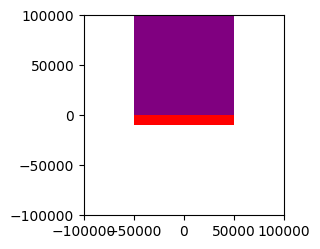

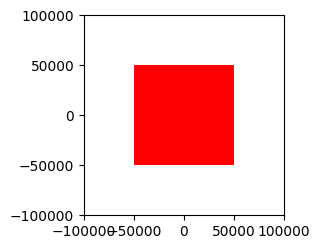

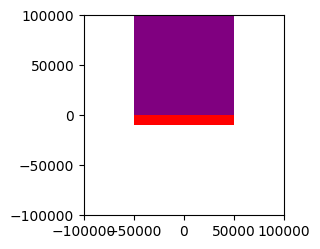

In [4]:
#ground surface
air_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -50000, 50000, 0, 100000)
air_cell = openmc.Cell(region=-air_surface, fill=air)

ground_surface = openmc.model.RectangularParallelepiped(-50000, 50000, -50000, 50000, -10000, 0)
ground_cell = openmc.Cell(region=-ground_surface, fill=ground_material)

xmin = openmc.XPlane(x0=-50001, boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=50001, boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=-50001, boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=50001, boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=-10001, boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=100001, boundary_type = 'vacuum')

void_region = +xmin & -xmax & -ymax & +ymin & +zmin & -zmax

void_cell =  openmc.Cell(region=void_region)

universe = openmc.Universe(cells=[air_cell, void_cell, ground_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()
color_assignment = {void_cell: 'blue', ground_cell: 'red', air:'purple'}
plt.show(universe.plot(width=(200000, 200000), basis='xz', colors=color_assignment))
plt.show(universe.plot(width=(200000, 200000), basis='xy', colors=color_assignment))
plt.show(universe.plot(width=(200000, 200000), basis='yz', colors=color_assignment))



In [5]:
from math import cos, pi
#create the source
sett = openmc.Settings()
sett.particles = 100000
sett.batches = 5
sett.inactive = 0
sett.run_mode = 'fixed source'

source = openmc.Source()
source.particle = 'neutron'
source.energy = openmc.stats.Discrete([1e7], [1])
source.angle = openmc.stats.Isotropic()
source.space = openmc.stats.Point((0,0,0))
sett.source = source

In [6]:
#mesh
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [1,1,20]
air_mesh.lower_left = [-50000,-50000 , 0]
air_mesh.upper_right = [50000,50000 , 100000]
mesh_filter = openmc.MeshFilter(air_mesh)

In [7]:
#tally

tallies = openmc.Tallies()

shine_tally = openmc.Tally(name='shine_tally')
neutron_filter = openmc.ParticleFilter(['neutron'])
#cell_filter = openmc.CellFilter(air_cell)
shine_tally.scores  = ['scatter', 'flux']
shine_tally.filters = [mesh_filter, neutron_filter]
tallies.append(shine_tally)

In [8]:
model = openmc.model.Model(geom, mats, sett, tallies)
!rm *.h5
results_filename = model.run()
results = openmc.StatePoint(results_filename)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [9]:
flux_tally = results.get_tally(name="shine_tally")
df = flux_tally.get_pandas_dataframe()
df

mesh 1        particle nuclide    score     mean std. dev.
        x  y   z                                             
0       1  1   1  neutron   total  scatter 4.41e+00  1.08e-02
1       1  1   1  neutron   total     flux 2.25e+04  2.49e+01
2       1  1   2  neutron   total  scatter 3.71e+00  8.35e-03
3       1  1   2  neutron   total     flux 1.67e+04  1.28e+01
4       1  1   3  neutron   total  scatter 3.11e+00  1.02e-02
5       1  1   3  neutron   total     flux 1.32e+04  2.25e+01
6       1  1   4  neutron   total  scatter 2.57e+00  1.56e-02
7       1  1   4  neutron   total     flux 1.05e+04  4.69e+01
8       1  1   5  neutron   total  scatter 2.09e+00  1.10e-02
9       1  1   5  neutron   total     flux 8.36e+03  3.13e+01
10      1  1   6  neutron   total  scatter 1.68e+00  6.81e-03
11      1  1   6  neutron   total     flux 6.58e+03  2.61e+01
12      1  1   7  neutron   total  scatter 1.31e+00  8.12e-03
13      1  1   7  neutron   total     flux 5.11e+03  2.65e+01
14      1  1   8  neutron   total  scatter 1.04e+00  5.35e-03
15      1  1   8  neutron   total     flux 3.99e+03  1.77e+01
16      1  1   9  neutron   total  scatter 8.13e-01  6.21e-03
17      1  1   9  neutron   total     flux 3.09e+03  1.94e+01
18      1  1  10  neutron   total  scatter 6.35e-01  3.91e-03
19      1  1  10  neutron   total     flux 2.40e+03  1.21e+01
20      1  1  11  neutron   total  scatter 4.94e-01  4.46e-03
21      1  1  11  neutron   total     flux 1.85e+03  8.78e+00
22      1  1  12  neutron   total  scatter 3.79e-01  3.87e-03
23      1  1  12  neutron   total     flux 1.41e+03  9.93e+00
24      1  1  13  neutron   total  scatter 2.85e-01  2.82e-03
25      1  1  13  neutron   total     flux 1.06e+03  8.53e+00
26      1  1  14  neutron   total  scatter 2.20e-01  1.90e-03
27      1  1  14  neutron   total     flux 8.14e+02  4.46e+00
28      1  1  15  neutron   total  scatter 1.68e-01  1.32e-03
29      1  1  15  neutron   total     flux 6.21e+02  2.90e+00
30      1  1  16  neutron   total  scatter 1.24e-01  1.10e-03
31      1  1  16  neutron   total     flux 4.60e+02  2.84e+00
32      1  1  17  neutron   total  scatter 9.21e-02  1.38e-03
33      1  1  17  neutron   total     flux 3.41e+02  3.70e+00
34      1  1  18  neutron   total  scatter 6.45e-02  1.52e-03
35      1  1  18  neutron   total     flux 2.41e+02  4.11e+00
36      1  1  19  neutron   total  scatter 4.13e-02  1.69e-03
37      1  1  19  neutron   total     flux 1.58e+02  5.22e+00
38      1  1  20  neutron   total  scatter 1.94e-02  1.06e-03
39      1  1  20  neutron   total     flux 8.30e+01  2.91e+00

In [16]:
distance_z = air_mesh.vertices[0,0,:,2]

In [18]:
flux = df[df['score'] == 'flux']
flux = flux["mean"]
flux

1     22488.265975
3     16662.840401
5     13226.886497
7     10530.737195
9      8357.608382
11     6583.309864
13     5105.007883
15     3985.568489
17     3086.982574
19     2395.731080
21     1852.496278
23     1412.590417
25     1063.163217
27      814.243512
29      621.101500
31      459.521771
33      341.175577
35      241.383046
37      158.226431
39       82.979937
Name: mean, dtype: float64

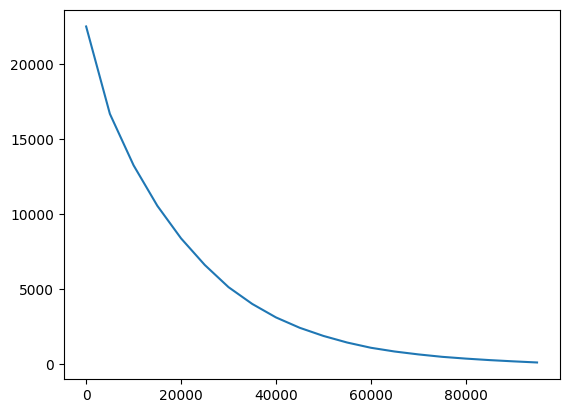

In [20]:
plt.plot(distance_z[:-1], flux)